现在我知道我应该考虑列向量，而Tensorflow对数据的形状非常挑剔。 但是在numpy中，正常的一维ndarray已经被表示为列向量。 如果我重新塑造$\mathbb{R}^n$ 为 $\mathbb{R}^{n\times1}$，它不再是列向量了，而是是1列的矩阵,那使用scipy会有麻烦。 *所以我们应该把TensorFlow的数据视为特殊情况。 我们继续使用numpy的惯例。

浅谈在matplotlib中更改plt.plot()的绘图风格：   https://blog.csdn.net/qq_42505705/article/details/84962815

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report  # 评价报告

In [2]:
plt.style.use('fivethirtyeight')

### 准备数据

In [3]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.tail()

,exam1,exam2,admitted
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1
99,74.775893,89.529813,1


In [4]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


https://blog.csdn.net/qq_39949963/article/details/80773588
seaborn lmplot :http://seaborn.pydata.org/generated/seaborn.lmplot.html

/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/seaborn/regression.py:576: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


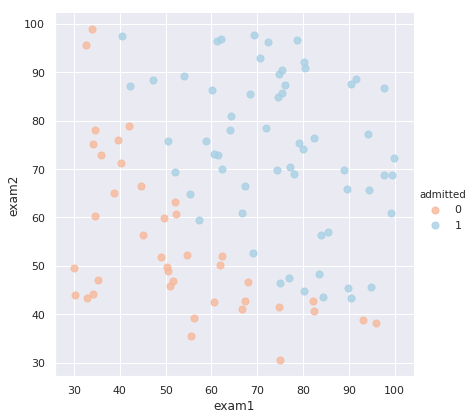

In [5]:
sns.set(context='notebook', style='darkgrid', palette=sns.color_palette('RdBu', 2))
# implot 回归图
sns.lmplot('exam1', 'exam2', hue='admitted', data=data, size=6, fit_reg=False, scatter_kws={"s":50})
plt.show()

In [6]:
def get_X(df):
    # 读取特征
    df.insert(0, 'ones', value=1)
    # df.iloc[:,0:-1].values  这里用values得到的是同样的类型，但是在后续处理时会报错，不清楚为啥？？？
    # as_matrix()返回的不是矩阵，而是ndarray
    return df.iloc[:,0:-1].as_matrix()

def get_y(df):
    # 读取标签
    return df.iloc[:, -1].as_matrix()

def normalize_feature(df):
    # 特征缩放
    return df.apply(lambda column: (column - np.mean(column))/np.std(column))


In [7]:
X = get_X(data)
print(X.shape)
y = get_y(data)
print(y.shape)

(100, 3)
(100,)


/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


### sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为：$$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$合起来，我们得到逻辑回归模型的假设函数：$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

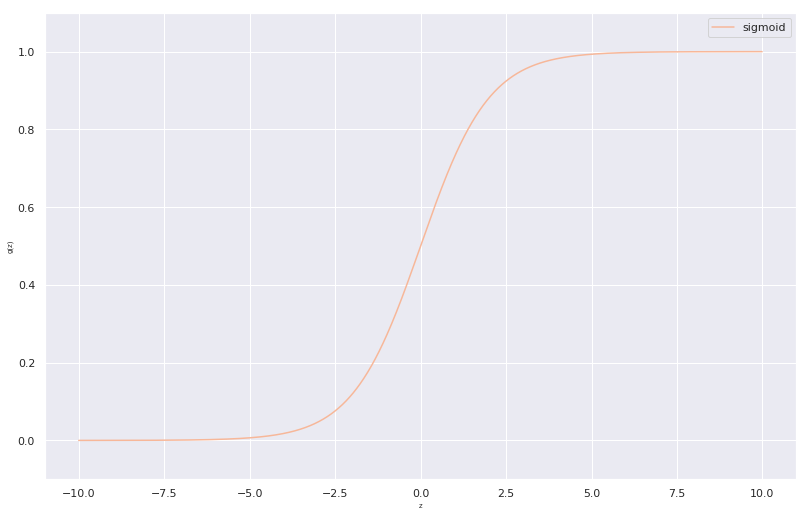

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(-10, 10, 0.01), sigmoid(np.arange(-10, 10, 0.01)), label='sigmoid')
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('z', fontsize=7)
ax.set_ylabel('g(z)', fontsize=7)
ax.legend()
plt.show()

cost function(代价函数)
$$\begin{align} & J\left( \theta \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ \end{align}$$

In [10]:
def cost(theta, X, y):
    # 计算代价函数
    # y是数组,这里的*是对于位置上元素相乘的结果，不是矩阵的乘法，需要注意！
    # 这里为啥是np.mean(),原因是使用向量的乘法来计算结果，导致mean里面的计算结果为2维的（100,100）的数组
    return np.mean(-y*np.log(sigmoid(X@theta)) - (1-y)*np.log(1-sigmoid(X@theta)))


In [11]:
theta = np.zeros(3)
# theta是列向量,这里一定要注意！！所以表示成矩阵为3行1列，即为3 ×１
theta.shape, theta

((3,), array([0., 0., 0.]))

In [12]:
(-y*np.log(sigmoid(X@theta))).shape, y.shape, (-y*np.log(sigmoid(X@theta)) - (1-y)*np.log(1-sigmoid(X@theta))).shape

((100,), (100,), (100,))

In [13]:
cost(theta, X, y)

0.6931471805599453

gradient descent(梯度下降)¶
这是批量梯度下降（batch gradient descent）
转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$ $$\frac{\partial J\left( \theta \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [14]:
def batch_gradient_descent(theta, X, y):
    # 计算梯度下降
    inner = X.T @ (sigmoid(X @ theta) - y)

    return (1 / len(X)) * inner

In [15]:
g = batch_gradient_descent(theta, X, y)

In [16]:
g

array([ -0.1       , -12.00921659, -11.26284221])

### 拟合参数
https://www.jb51.net/article/180064.htm

In [17]:
import scipy.optimize as opt

In [18]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=batch_gradient_descent)

In [19]:
print(res)

     fun: 0.20349770222614316
     jac: array([1.75407384e-06, 5.42100922e-05, 2.39246043e-04])
 message: 'Optimization terminated successfully.'
    nfev: 74
    nhev: 0
     nit: 30
    njev: 263
  status: 0
 success: True
       x: array([-25.16340284,   0.20624827,   0.20148834])


### 用训练集数据预测和验证

In [20]:
def predict(theta, X):
    prod = sigmoid(X @ theta)
    return (prod >= 0.5).astype(int)

In [21]:
final_theta = res.x
y_pred = predict(final_theta, X)

In [22]:
y_pred

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [23]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



机器学习笔记－－classification_report&精确度/召回率/F1值: https://blog.csdn.net/akadiao/article/details/78788864

### 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier

$X \times \theta = 0$ (this is the line)

In [24]:
# 计算出来的最终的theta
print(res.x)

[-25.16340284   0.20624827   0.20148834]


In [25]:
res.x * final_theta

array([6.33196843e+02, 4.25383471e-02, 4.05975525e-02])

In [26]:
# 这里的参数为啥是负数，我觉得是根据上面的图片，推测出其斜率为负数
coef = -(res.x / res.x[2])
print(coef)

[124.8876358   -1.02362381  -1.        ]


In [27]:
x = np.arange(130, step=0.1)
y = coef[0] + coef[1] * x

In [28]:
# 查看data的数据分布
data.describe()

,ones,exam1,exam2,admitted
count,100.0,100.000000,100.000000,100.000000
mean,1.0,65.644274,66.221998,0.600000
std,0.0,19.458222,18.582783,0.492366
min,1.0,30.058822,30.603263,0.000000
25%,1.0,50.919511,48.179205,0.000000
50%,1.0,67.032988,67.682381,1.000000
75%,1.0,80.212529,79.360605,1.000000
max,1.0,99.827858,98.869436,1.000000


### 画图

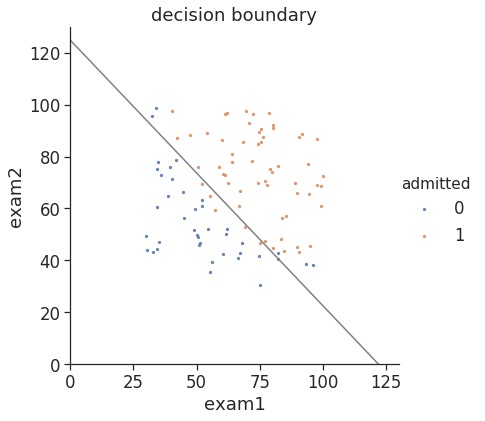

In [29]:
sns.set(context='notebook', style='ticks', font_scale=1.5)
sns.lmplot('exam1', 'exam2', hue='admitted', data=data, size=6, fit_reg=False, scatter_kws={'s': 5})

plt.plot(x, y, 'gray')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('decision boundary')
plt.show()

## 正则化逻辑回归

In [30]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head(),df.shape

(      test1    test2  accepted
 0  0.051267  0.69956         1
 1 -0.092742  0.68494         1
 2 -0.213710  0.69225         1
 3 -0.375000  0.50219         1
 4 -0.513250  0.46564         1, (118, 3))

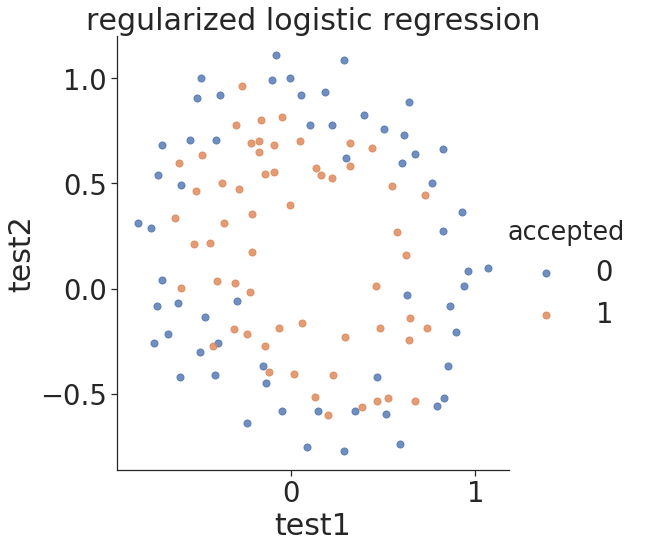

In [31]:
sns.set(context='notebook', style='ticks', font_scale=2.5)
sns.lmplot('test1', 'test2', data=df, hue='accepted', size=8, fit_reg=False, scatter_kws={'s': 50})

plt.title('regularized logistic regression')
plt.show()


## feature mapping（特征映射）
polynomial expansion: 多项式展开

for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p

In [98]:

def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    #  np.power(2, 3)=8  --> 2的3次方
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)
    data = {"f{}{}".format(i-p, p): np.power(x, i-p) * np.power(y, p)
               for i in np.arange(power + 1)
               for p in np.arange(i + 1)
           }
    if as_ndarray:
        data = pd.DataFrame(data).as_matrix()
    else:
        data = pd.DataFrame(data)
    return data

In [99]:
x1 = df.test1
x2 = df.test2

In [100]:
data = feature_mapping(x1, x2, power=6)


In [101]:
len(data.iloc[0]), data.shape

(28, (118, 28))

In [102]:
data.iloc[0]

f00    1.000000e+00
f01    6.995600e-01
f02    4.893842e-01
f03    3.423536e-01
f04    2.394969e-01
f05    1.675424e-01
f06    1.172060e-01
f10    5.126700e-02
f11    3.586434e-02
f12    2.508926e-02
f13    1.755144e-02
f14    1.227829e-02
f15    8.589398e-03
f20    2.628305e-03
f21    1.838657e-03
f22    1.286251e-03
f23    8.998098e-04
f24    6.294709e-04
f30    1.347453e-04
f31    9.426244e-05
f32    6.594223e-05
f33    4.613055e-05
f40    6.907989e-06
f41    4.832553e-06
f42    3.380660e-06
f50    3.541519e-07
f51    2.477505e-07
f60    1.815630e-08
Name: 0, dtype: float64

In [103]:
data.head()

,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
0,1.0,0.69956,0.489384,0.342354,0.239497,0.167542,0.117206,0.051267,0.035864,0.025089,...,0.000135,0.000094,0.000066,0.000046,0.000007,0.000005,0.000003,3.541519e-07,2.477505e-07,1.815630e-08
1,1.0,0.68494,0.469143,0.321335,0.220095,0.150752,0.103256,-0.092742,-0.063523,-0.043509,...,-0.000798,-0.000546,-0.000374,-0.000256,0.000074,0.000051,0.000035,-6.860919e-06,-4.699318e-06,6.362953e-07
2,1.0,0.69225,0.479210,0.331733,0.229642,0.158970,0.110047,-0.213710,-0.147941,-0.102412,...,-0.009761,-0.006757,-0.004677,-0.003238,0.002086,0.001444,0.001000,-4.457837e-04,-3.085938e-04,9.526844e-05
3,1.0,0.50219,0.252195,0.126650,0.063602,0.031940,0.016040,-0.375000,-0.188321,-0.094573,...,-0.052734,-0.026483,-0.013299,-0.006679,0.019775,0.009931,0.004987,-7.415771e-03,-3.724126e-03,2.780914e-03
4,1.0,0.46564,0.216821,0.100960,0.047011,0.021890,0.010193,-0.513250,-0.238990,-0.111283,...,-0.135203,-0.062956,-0.029315,-0.013650,0.069393,0.032312,0.015046,-3.561597e-02,-1.658422e-02,1.827990e-02


In [104]:
data.describe()

,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
count,118.0,118.000000,118.000000,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.183102,0.301370,0.142350,1.710985e-01,0.115710,1.257256e-01,0.054779,-0.025472,0.015483,...,5.983333e-02,-0.005251,9.432094e-03,-0.001705,1.225384e-01,0.011812,1.893340e-02,5.196507e-02,-0.000703,7.837118e-02
std,0.0,0.519743,0.284536,0.326134,2.815658e-01,0.299092,2.964416e-01,0.496654,0.224075,0.150143,...,2.746459e-01,0.096738,5.455787e-02,0.037443,2.092709e-01,0.072274,3.430092e-02,2.148098e-01,0.058271,1.938621e-01
min,1.0,-0.769740,0.000026,-0.456071,6.855856e-10,-0.270222,1.795116e-14,-0.830070,-0.484096,-0.483743,...,-5.719317e-01,-0.296854,-1.592528e-01,-0.113448,1.612020e-09,-0.246068,2.577297e-10,-3.940702e-01,-0.203971,6.472253e-14
25%,1.0,-0.254385,0.061086,-0.016492,3.741593e-03,-0.001072,2.298277e-04,-0.372120,-0.178209,-0.042980,...,-5.155632e-02,-0.029360,-3.659760e-03,-0.005749,1.869975e-03,-0.001926,1.258285e-04,-7.147973e-03,-0.006381,8.086369e-05
50%,1.0,0.213455,0.252195,0.009734,6.360222e-02,0.000444,1.604015e-02,-0.006336,-0.016521,-0.000039,...,-2.544062e-07,-0.000512,-1.473547e-07,-0.000005,2.736163e-02,0.000205,3.387050e-03,-1.021440e-11,-0.000004,4.527344e-03
75%,1.0,0.646562,0.464189,0.270310,2.155453e-01,0.113020,1.001215e-01,0.478970,0.100795,0.079510,...,1.099616e-01,0.015050,1.370560e-02,0.001024,1.520801e-01,0.019183,2.090875e-02,2.526861e-02,0.002104,5.932959e-02
max,1.0,1.108900,1.229659,1.363569,1.512062e+00,1.676725,1.859321e+00,1.070900,0.568307,0.505577,...,1.228137e+00,0.369805,2.451845e-01,0.183548,1.315212e+00,0.304409,2.018260e-01,1.408460e+00,0.250577,1.508320e+00


## regularized cost（正则化代价函数）¶
$$J\left( \theta \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [105]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [106]:
def regularized_cost(theta, X, y, l=1):
    # 逻辑回归的正则化代价函数
    
    # 常数项不参与正则化
    theta_j1_to_n = theta[1:]
    
    regularized_term = (l / (2*len(x))) * np.power(theta_j1_to_n, 2).sum()
    
    return cost(theta, X, y) + regularized_term
    

In [107]:
regularized_cost(theta, X, y)

0.6931471805599454

因为我们设置theta为0，所以这个正则化代价函数与代价函数的值相同

## regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)x^{(i)}+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{ for j}\ge \text{1}$$

In [108]:
def regularized_gradient(theta, X, y, lam=1):
    # 计算逻辑回归函数的正则化梯度下降
    
    theta_j1_to_n = theta[1:]
    temp = (lam / len(X) * theta_j1_to_n)
    
    # 常数项不参与正则化  concatenate
    regularized_term = np.concatenate([np.array([0]), temp])
    return batch_gradient_descent(theta, X, y) + regularized_term

In [109]:
regularized_gradient(theta, X, y)

array([8.47457627e-03, 7.77711864e-05, 3.76648474e-02, 2.34764889e-02,
       3.93028171e-02, 3.10079849e-02, 3.87936363e-02, 1.87880932e-02,
       1.15013308e-02, 8.19244468e-03, 3.09593720e-03, 4.47629067e-03,
       1.37646175e-03, 5.03446395e-02, 7.32393391e-03, 1.28600503e-02,
       5.83822078e-03, 7.26504316e-03, 1.83559872e-02, 2.23923907e-03,
       3.38643902e-03, 4.08503006e-04, 3.93486234e-02, 4.32983232e-03,
       6.31570797e-03, 1.99707467e-02, 1.09740238e-03, 3.10312442e-02])

### 拟合参数

In [110]:
import scipy.optimize as opt

In [111]:
print("init cost:{}".format(regularized_cost(theta, X, y)))

# 求regularized_cost的局部最优解
# newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost:0.6931471805599454


     fun: 0.4684619482558336
     jac: array([ 8.05810229e-05, -5.33971045e-05,  3.64258342e-05,  7.70601225e-05,
        3.37192274e-06,  3.83770244e-05, -1.62485173e-05, -1.51328825e-06,
        8.75212319e-05, -5.88535218e-05,  1.69826669e-05, -2.84483977e-05,
        5.05786477e-07, -8.98222572e-06, -7.13114458e-05, -5.78821960e-05,
       -1.08588565e-05, -2.31821378e-05,  5.63534468e-05, -2.26323986e-05,
       -3.87698146e-05, -1.74226475e-05, -3.85285254e-05, -4.74142365e-05,
       -3.22759326e-05,  4.29473041e-05, -2.31932338e-05, -2.92956833e-05])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 22
    nhev: 0
     nit: 3
    njev: 47
  status: 2
 success: False
       x: array([ 1.27355932,  1.17771759, -1.42932403, -0.16833022, -1.19437089,
       -0.45448986, -0.92857777,  0.62398874, -0.90970525, -0.36355362,
       -0.27327228, -0.29823335, -0.1439104 , -2.01895427, -0.37114422,
       -0.62107271, -0.27848559, -0.32959143,  0

In [112]:
# 预测
final_theta = res.x
y_pred = predict(final_theta, X)

print('y_pred:{}'.format(y_pred))

print(classification_report(y, y_pred))

y_pred:[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 1 0 0 1]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



## 使用不同的 $\lambda$ （这个是常数）
## 画出决策边界
 - 我们找到所有满足 $X\times \theta = 0$ 的x
 - instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [113]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    # 取数
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)
    
    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])
    print(X.shape, y.shape, theta.shape)
    
    # 求最小化的代价函数
    # jac: 返回梯度向量的函数
    res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y, l), method='TNC', jac=regularized_gradient)
    
    return res.x

In [120]:
def find_decision_boundary(density, power, theta, threshold):
    # 查找决策边界
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)
    
    # 坐标
    cordinates = [(x, y) for x in t1 for y  in t2]
    x_cord, y_cord = zip(*cordinates)
    
    # 以下步骤未看懂
    mapped_cord = feature_mapping(x_cord, y_cord, power)

    inner_product = mapped_cord.as_matrix() @ theta
    
    decision = mapped_cord[np.abs(inner_product) < threshold]
    
    return decision.f10, decision.f01   
       

In [121]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    # 密度
    density = 1000
    # 阈值
    threshold = 2 * 10 ** -3
    
    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={'s': 10})
    
    plt.scatter(x, y, s=10)
    plt.title('decision boundary')
    plt.show()
        

/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(118, 28) (118,) (28,)


/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


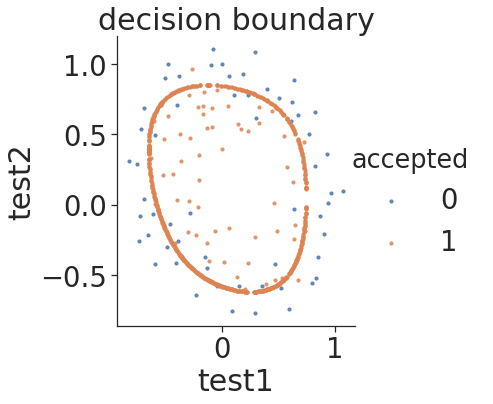

In [122]:
draw_boundary(power=6, l=1)

/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(118, 28) (118,) (28,)


/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/seaborn/regression.py:576: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


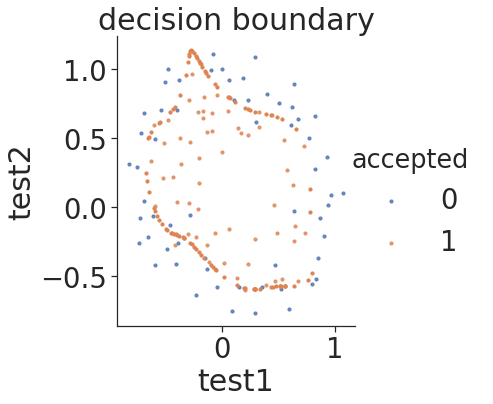

In [123]:
# no regularization, over fitting，#lambda=0,没有正则化，过拟合了
draw_boundary(power=6, l=0)

/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(118, 28) (118,) (28,)


/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home/deploy/.virtualenvs/ml_env_py35/lib/python3.5/site-packages/seaborn/regression.py:576: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


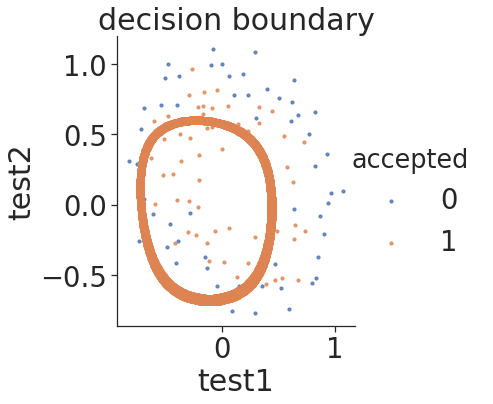

In [124]:
draw_boundary(power=6, l=100)  # 欠拟合